In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

from sklearn.model_selection import train_test_split

from torch.utils.data import Subset

In [2]:
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b6'  

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=15)

528
Loaded pretrained weights for efficientnet-b6


In [3]:
path_train = '/tf/KAIER_2022/Battery_data/origin_data/'
# path_valid =  '/tf/KAIER_2022/Battery_data/origin_data/valid'

train_dataset = torchvision.datasets.ImageFolder(root=path_train, transform=transforms.Compose([ 
                                                transforms.Resize(224), 
                                                transforms.ToTensor() ])) 


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# valid_dataset = torchvision.datasets.ImageFolder(root=path_valid, transform=transforms.Compose([ 
#                                                 transforms.Resize(224), 
#                                                 transforms.ToTensor() ])) 


# valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True)


# test_dataset = torchvision.datasets.ImageFolder(root=path_test, transform=transforms.Compose([ 
#                                                 transforms.Resize(224), 
#                                                 transforms.ToTensor() ])) 


# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

In [4]:
print(np.unique(train_dataset.targets))
# print(np.unique(valid_dataset.targets))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [5]:
images, labels = next(iter(train_dataloader))
images.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [6]:
print(len(train_dataset))
# print(len(test_dataset))

21717


In [7]:
train_idx, valid_idx = train_test_split(range(len(train_dataset)), stratify=train_dataset.targets, test_size=0.3, random_state=42)

In [8]:
print(len(train_idx))
print(len(valid_idx))

15201
6516


In [9]:
trainset = Subset(train_dataset, train_idx)
validset = Subset(train_dataset, valid_idx)

In [10]:
print(len(trainset))
print(len(validset))

15201
6516


In [11]:
np.unique(np.array(train_dataset.targets)[train_idx], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 102,   20, 2438, 9508,  143,    7,  794,    8,   48, 1186,  431,
          10,   73,  411,   22]))

In [12]:
train_dataset.class_to_idx

{'무지부 기재연결부': 0,
 '무지부 주름': 1,
 '무지부 줄무늬': 2,
 '코팅부 경계부 불량': 3,
 '코팅부 기재연결부': 4,
 '코팅부 라벨지': 5,
 '코팅부 미코팅': 6,
 '코팅부 백점': 7,
 '코팅부 버블': 8,
 '코팅부 접힘': 9,
 '코팅부 줄무늬': 10,
 '코팅부 찍힘': 11,
 '코팅부 코팅불량': 12,
 '코팅부 테이프': 13,
 '코팅부 흑점': 14}

In [13]:
batch_size = 32

dataloaders = {}

dataloaders['train'] = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

dataloaders['valid'] = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                   shuffle=False, num_workers=0)


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'save/finetune/efficientnetb6_15class.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [15]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.01,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [16]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model,criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.17 Acc: 96.0
valid Loss: 0.04 Acc: 99.2
==> best model saved - 0 / 99.2
Epoch 1/49
----------
train Loss: 0.03 Acc: 99.2
valid Loss: 0.01 Acc: 99.8
==> best model saved - 1 / 99.8
Epoch 2/49
----------
train Loss: 0.01 Acc: 99.7
valid Loss: 0.01 Acc: 99.9
==> best model saved - 2 / 99.9
Epoch 3/49
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.00 Acc: 99.9
==> best model saved - 3 / 99.9
Epoch 4/49
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.00 Acc: 99.9
Epoch 5/49
----------
train Loss: 0.00 Acc: 99.9
valid Loss: 0.00 Acc: 100.0
==> best model saved - 5 / 100.0
Epoch 6/49
----------
train Loss: 0.01 Acc: 99.9
valid Loss: 0.00 Acc: 100.0
Epoch 7/49
----------
train Loss: 0.00 Acc: 99.9
valid Loss: 0.00 Acc: 100.0
Epoch 8/49
----------
train Loss: 0.00 Acc: 99.9
valid Loss: 0.00 Acc: 99.9
Epoch 9/49
----------
train Loss: 0.00 Acc: 99.9
valid Loss: 0.00 Acc: 99.9
Epoch 10/49
----------
train Loss: 0.00 Acc: 99.9
valid Loss: 0.00 Acc: 100.

best model : 5 - 100 / 0.0


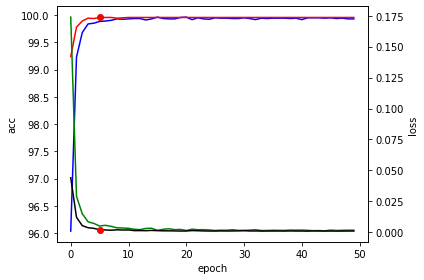

In [17]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()